# Text Generation using LSTMs

Text generation is a subset of language modeling, a foundational problem in various natural language processing (NLP) tasks such as speech-to-text conversion, chatbots, and automatic summarization. Language models predict the probability of a word based on preceding words in text data, operating at various levels including character, n-gram, sentence, and paragraph. In this tutorial, we will delve into constructing a language model capable of generating realistic text by employing and training a cutting-edge Recurrent Neural Network (RNN).  

### Generating News headlines 

We will focus on creating a model trained on the New York Times Comments and Headlines dataset. This model will be designed to synthesize news headlines, showcasing the practical application of our language model.


## Import the libraries

The initial step involves importing essential libraries required for our project:

In [126]:
%pip install keras
%pip install tensorflow
%pip install nltk rouge
%pip install wordcloud



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     ---------------------- ---------------- 92.2/162.8 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 162.8/162.8 kB 2.4 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp310-cp310-win_amd64.whl.metadata (6.5 kB)
   ---------------------------------------- 0.0/300.0 kB ? eta -:--:--
   --------------- ------------------------ 112.6/300.0 kB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 300.0/300.0 kB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
    --------------------------------------- 0.1/7.7 MB 4.2 MB/s eta 0:00:02
   - -------------------------------------- 0.3/7.7 M

In [5]:
import pandas as pd
import numpy as np
import string, os 
import nltk
nltk.download('punkt')

# TensorFlow's Keras module for building LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku 
from tensorflow.keras.preprocessing.text import Tokenizer


# Set seeds for reproducibility
import tensorflow as tf
from numpy.random import seed
tf.random.set_seed(2)
seed(1)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

warnings.simplefilter(action='ignore', category=FutureWarning)

## Load the dataset and clean it

Load the dataset of news headlines. Fetch the headline column of the data, remove all rows that have "unknown" as the input value. Reduce the data to lower case, remove all punctuations, and create a list of valid headlines to train the GRU model.

['finding an expansive view  of a forgotten people in niger', 'and now  the dreaded trump curse', 'venezuela’s descent into dictatorship', 'stain permeates basketball blue blood', 'taking things for granted', 'the caged beast awakens', 'an everunfolding story', 'o’reilly thrives as settlements add up', 'mouse infestation', 'divide in gop now threatens trump tax plan']


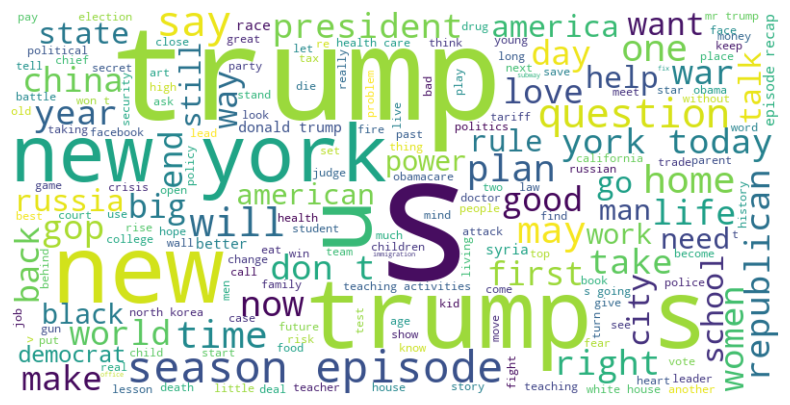

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Replace 'path/to/your/csvfile.csv' with the actual path to your CSV file
file_path = 'Combined_Articles.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Assuming 'headline' is the name of the column you're interested in
# Select the 'headline' column and convert it to a list
corpus = df['headline'].tolist()

# Now, headlines_list contains all the headlines as a list of strings
# print(corpus)

cleaned_corpus = []
for headline in corpus:
    # Remove 'unknown' headlines
    if headline.lower() != 'unknown':
        # Strip leading/trailing spaces, convert to lower case, and remove punctuation
        cleaned_headline = headline.strip().lower()
        cleaned_headline = cleaned_headline.translate(str.maketrans('', '', string.punctuation))
        cleaned_corpus.append(cleaned_headline)


corpus = cleaned_corpus

for idx,_ in enumerate(corpus):
    corpus[idx] = corpus[idx].strip()
print(corpus[0:10])

text = ' '.join(corpus)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off the axis
plt.show()

### Creating N-gram Sequences for Language Modeling

Language modeling relies on sequential input data to predict the next word or token in a sequence. An essential process in preparing this sequential data is tokenization, where we break down the corpus into its constituent tokens (words or terms). Keras, a Python library, offers a built-in method for tokenization, allowing us to easily extract tokens and their corresponding indices in the corpus. Through tokenization, each text document in the dataset is transformed into a sequence of tokens, laying the groundwork for sequence prediction tasks.


In [61]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[10:20]

[[7, 69, 1],
 [7, 69, 1, 5221],
 [7, 69, 1, 5221, 10],
 [7, 69, 1, 5221, 10, 5222],
 [3351, 5223],
 [3351, 5223, 67],
 [3351, 5223, 67, 3352],
 [2452, 5224],
 [2452, 5224, 2453],
 [2452, 5224, 2453, 888]]


**Headline:** "global leaders convene for climate summit"  

Following the tokenization process, where each unique word is assigned a numeric index, let's assume the following mappings in our vocabulary:

global: 45
leaders: 506
convene: 82
for: 9
climate: 321
summit: 212

**Ngrams:** | **Sequence of Tokens**

<table>
<tr><td>Ngram </td><td> Sequence of Tokens</td></tr>
<tr> <td>global </td><td> 	[45] </td></tr>
<tr> <td>global leaders </td><td> [45, 506] </td></tr>
<tr> <td>global leaders convene for</td><td> [45, 506, 82] </td></tr>
<tr> <td>global leaders convene for climate </td><td> [45, 506, 82, 9, 321] </td></tr>
<tr> <td>global leaders convene for climate summit </td><td> [45, 506, 82, 9, 321, 212] </td></tr>
</table>



### Padding Sequences and Creating Predictors and Target

Considering the varying lengths of sequences, we pad them for uniformity and create predictors (n-gram sequences) and labels (next word in the sequence). Let's see this with another example:


**Headline:**   "tech giants invest in renewable energy"

Assuming our vocabulary assigns the following indices:

tech: 58
giants: 409
invest: 102
in: 5
renewable: 278
energy: 91
After tokenizing and generating n-grams, we prepare our dataset as follows:

<table>
<tr><td>PREDICTORS </td> <td>           LABEL </td></tr>
<tr><td>tech                   </td> <td>  giants</td></tr>
<tr><td>tech giants               </td> <td>  invest</td></tr>
<tr><td>tech giants invest      </td> <td>  in</td></tr>
<tr><td>tech giants invest in </td> <td>  renewable</td></tr>
<tr><td>tech giants invest in renewable </td> <td>  energy</td></tr>
</table>

This table showcases how each n-gram sequence acts as a predictor for the next word in the sequence, which is used as the label. This approach is fundamental in training models for text generation, as it teaches the model to predict the next word based on the context provided by the sequence of previous words.

In [75]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

print("Predictors shape:", predictors.shape)
print("Label shape:", label.shape)

Predictors shape: (51840, 23)
Label shape: (51840, 12150)



## GRUs for Text Generation


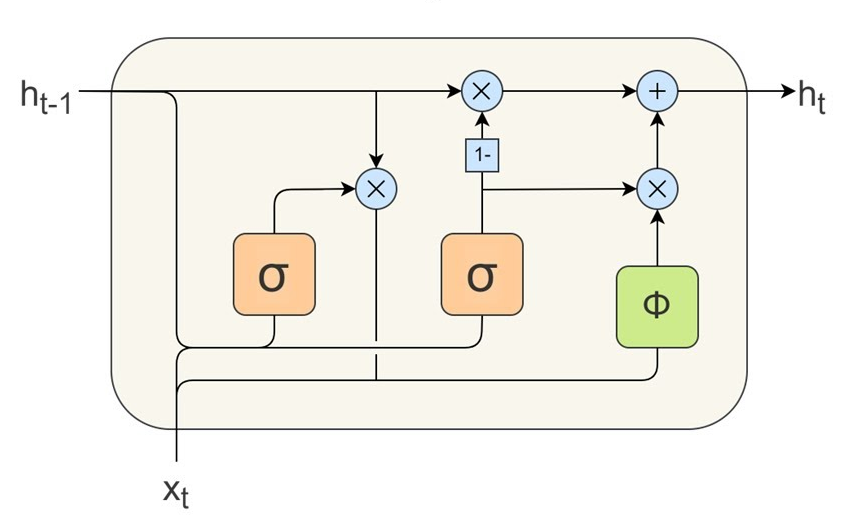
In contrast to feed-forward neural networks where activations flow solely in one direction (from input to output), Recurrent Neural Networks (RNNs) allow activations to travel in loops from input to output and back again. This looping architecture endows RNNs with a form of 'memory', enabling them to retain information about what has been processed so far.

While this memory capability offers a significant advantage over traditional neural networks, RNNs are often plagued by the Vanishing Gradient problem. This issue makes it challenging for the network to learn and adjust the parameters of initial layers in a deep network structure. To overcome this limitation, a specialized variant of RNNs known as Long Short-Term Memory (LSTM) models were introduced, featuring an additional 'cell state'.

Gated Recurrent Units (GRUs) are another innovative solution designed to address the vanishing gradient problem, offering a simpler alternative to LSTMs. GRUs streamline the model architecture by combining the forget and input gates into a single update gate. They also merge the cell state and hidden state, resulting in a model that is easier to compute and understand while still capable of capturing long-term dependencies.

GRUs maintain the ability to modulate the flow of information like LSTMs but with fewer parameters, making them faster to train without a significant loss in performance. Let's incorporate a GRU model in our project with the following layers:

1. Input Layer: Accepts the sequence of words as input.
2. GRU Layer: Utilizes GRU units to process the input. For our initial model, we'll include 100 units, although this number can be adjusted for optimization.
3. Dropout Layer: Serves as a regularization layer that randomly disables a fraction of neurons in the GRU layer, helping to mitigate overfitting. This layer is optional but recommended.
4. Output Layer: Calculates the probability of the most likely next word as output.

We will run this model for total 100 epoochs but it can be experimented further.

Lets train our model now

In [96]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(GRU(200))
    model.add(Dropout(0.2))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)

input_len = max_sequence_len - 1
model.build(input_shape=(None, input_len))
model.summary()

c:\Users\sanat\repos\NLP\NLP Final Project\.venv\lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 23, 10)         │       121,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 200)            │       127,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 12150)          │     2,442,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,690,850 (10.26 MB)

 Trainable params: 2,690,850 (10.26 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
model.fit(predictors, label, epochs=100)

Epoch 1/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 8.1379
Epoch 2/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 7.1703
Epoch 3/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 6.8216
Epoch 4/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 6.5103
Epoch 5/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 6.2164
Epoch 6/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 5.9453
Epoch 7/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 5.6713
Epoch 8/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 5.3974
Epoch 9/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - loss: 5.1365
Epoch 10/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - loss: 4.9184
Epoch 11/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 4.6442
Epoch 12/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - loss: 4.3877
Epoch 13/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - loss: 4.2245
Epoch 14/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - 

##  Text Generation 

With our model architecture established, it's time to train it on our dataset. Following training, we'll develop a function to predict the subsequent word given a set of input words (seed text). This involves tokenizing the seed text, padding the sequences for uniformity, and then feeding them into our trained model to obtain predictions. By concatenating multiple predicted words, we can assemble a coherent sequence of predicted text.


In [82]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_text(seed_text, next_words, model, max_sequence_len, tokenizer):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted, axis=-1)[0]
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text.title()




## 6. Some Results


In [181]:
# Note: Ensure you pass the 'tokenizer' to your function call as well.
print("Input: The third season")
print("Model: "+generate_text("The third season", 3, model, max_sequence_len, tokenizer))

print("Input: Raising capital to")
print("Model: "+generate_text("Raising capital to", 14, model, max_sequence_len, tokenizer))

print("Input: New York Today Sees")
print("Model: "+generate_text("New York Today Sees", 8, model, max_sequence_len, tokenizer))

Input: The third season
Model: The Third Season Of The Great
Input: Raising capital to
Model: Raising Capital To 3 Health Care Bill Is A Genius Of 2018 Plans For The United States
Input: New York Today Sees
Model: New York Today Sees A Deal To All In The United States’


In [193]:
import math
#Data preparation for BLEU 
hypotheses = []
references = []

#Fetch 10 percent of the data
sample_corpus = corpus[0:math.ceil(len(corpus)*1)]
print(len(sample_corpus))

for headline in sample_corpus:
    #Fetch the first 30 percent of the words, generate the headlines with the model
    all_words = headline.split(' ')
    seed_words =' '.join(all_words[0:math.ceil(len(all_words)*0.3)])
    model_response = generate_text(seed_words, len(all_words)-len(seed_words.split(' ')), model, max_sequence_len, tokenizer)
    references.append([headline.lower()])
    hypotheses.append(model_response.lower()) 

# print(f'References {references} Hypothesis {hypotheses}')


8603


In [195]:
from nltk.translate.bleu_score import corpus_bleu

# Tokenize hypotheses and references
tokenized_hypotheses = [nltk.word_tokenize(sent.lower()) for sent in hypotheses]
tokenized_references = [[nltk.word_tokenize(ref.lower()) for ref in refs] for refs in references]

# Calculate BLEU score
bleu_score = corpus_bleu(tokenized_references, tokenized_hypotheses)
print("BLEU Score:", bleu_score)


BLEU Score: 0.3487263116860887


## Enhancing Model Performance

The model has generated outputs that are reasonably coherent. However, there's always room for improvement. Here are some strategies that could potentially enhance the model's performance:

- Incorporating Additional Data: Expanding the training dataset can provide the model with more examples to learn from, potentially improving its understanding and predictions.
- Refining the Network Architecture: Adjusting the structure of the neural network, such as adding more layers or experimenting with different types of layers, might yield better results.
- Optimizing Network Parameters: Fine-tuning the model's parameters, including learning rate, dropout rates, and others, can help in achieving a more accurate and robust model.
If you found this notebook helpful, please consider giving it an upvote. Thank you for exploring these concepts with me!